# Exploratory Data Analysis (EDA) and data cleaning notebook #

### Importing libraries and modules

In [1]:
# importing external libraries
from pathlib import Path
import os
import pandas as pd
import pickle
import json
import matplotlib.pyplot as plt
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn import set_config
set_config(transform_output = "pandas")

# Importing function to load data

# Making sure any changes are instantly added
%load_ext autoreload
%autoreload 2

from Modules.load_data import load_data
from Modules.preprocessing import missing_summary, merge_dfs, dollar_to_int, find_unique_values
from Modules.plotting import Plotter
from Modules.transforming import *
# Importing Pipelines
from Modules.Pipelines import general_transformation_pipeline1, general_transformation_pipeline2, general_transformation_pipeline3
from Modules.Pipelines import Pipeline_for_exploration1, Pipeline_for_exploration2, Pipeline_for_exploration3
from Modules.Pipelines import Pipeline1, Pipeline2, Pipeline3



### Loading and Merging Data

**Please unhash and run the cell below if you have not yet installed the dataset using the kaggle API**

In [2]:
#load_data()

**Obtaining absolute paths to datasets**

In [2]:
# Obtaining absolute path to data folder

data_folder = str(Path(os.getcwd()) / "data")

# Obtaining absolute paths to relevant datasets

cards_data = data_folder + "/cards_data.csv"
transaction_data = data_folder + "/transactions_data.csv"

**Please unhash if you have no yet merged the datasets**

In [3]:
'''
# Merging cards and transactions df and saving to pickle
# Unhash if this is the first time running the code

# Reading datasets into pandas
cards_data_df = pd.read_csv(cards_data)
transaction_data_df = pd.read_csv(transaction_data)

merge_dfs(transaction_data_df=transaction_data_df, cards_data_df=cards_data_df,data_folder=data_folder)
'''


In [4]:
# Loading the data from pickle

merged_df = pd.read_pickle(data_folder + "/merged_data.pkl")

In [5]:
# Load in mcc codes for later plotting
with open(data_folder + "/mcc_codes.json", "r") as file:
    mcc_data = json.load(file)

### Initial Observations

In [6]:
# Viewing head of merged_df
display(merged_df.head())

,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web,id,target
0,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN,Mastercard,Debit (Prepaid),5497590243197280,07/2022,306,YES,2,$55,05/2008,2008,No,7475327,No
1,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,NaN,Mastercard,Credit,5175842699412235,12/2024,438,YES,1,$9100,09/2005,2015,No,7475328,No
2,2010-01-01 00:02:00,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,NaN,Mastercard,Debit,5874992802287595,05/2020,256,YES,1,$14802,01/2006,2008,No,7475329,No
3,2010-01-01 00:06:00,848,3915,$46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,NaN,Visa,Debit,4354185735186651,01/2020,120,YES,1,$19113,07/2009,2014,No,7475332,No
4,2010-01-01 00:07:00,1807,165,$4.81,Swipe Transaction,20519,Bronx,NY,10464.0,5942,NaN,Mastercard,Debit (Prepaid),5207231566469664,03/2014,198,YES,1,$89,01/2008,2015,No,7475333,No


In [7]:
# Running info to see column types
merged_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8914963 entries, 0 to 8914962
Data columns (total 24 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   date                   object 
 1   client_id              int64  
 2   card_id                int64  
 3   amount                 object 
 4   use_chip               object 
 5   merchant_id            int64  
 6   merchant_city          object 
 7   merchant_state         object 
 8   zip                    float64
 9   mcc                    int64  
 10  errors                 object 
 11  card_brand             object 
 12  card_type              object 
 13  card_number            int64  
 14  expires                object 
 15  cvv                    int64  
 16  has_chip               object 
 17  num_cards_issued       int64  
 18  credit_limit           object 
 19  acct_open_date         object 
 20  year_pin_last_changed  int64  
 21  card_on_dark_web       object 
 22  id                

* As we can see a lot of columns that should be numerical are objects as they have dollar signs.
* A lot of columns need to be made numerical
* Dates to be represented as ordered time series

* `amount` and `credit limit` now changed to int types


* No outliers stand out

In [8]:
# Running missing summary
missing_summary(merged_df)

,Missing Values,Percentage missing (%)
date,0,0.000000
client_id,0,0.000000
card_id,0,0.000000
amount,0,0.000000
use_chip,0,0.000000
merchant_id,0,0.000000
merchant_city,0,0.000000
merchant_state,1047865,11.754003
zip,1107377,12.421555
mcc,0,0.000000


In [13]:
merged_df["errors"][merged_df["errors"].notna()]


161              Bad Expiration
180             Bad Card Number
262        Insufficient Balance
319        Insufficient Balance
320        Insufficient Balance
                   ...         
8914572    Insufficient Balance
8914610    Insufficient Balance
8914635    Insufficient Balance
8914782                 Bad PIN
8914898    Insufficient Balance
Name: errors, Length: 141767, dtype: object

* A lot of missing values for `errors` column. A missing value likely to mean there was no transaction error. So will take its own categorical encoding
* `zip` and `merchant_state` have a lot of missing values. These will also take their own categorical encoding in so much as this information may not be disclosed to hide fradulent transactions ...

In [14]:
find_unique_values(merged_df)

,columns,unique_no,unique_%
0,date,3680988,41.29
1,client_id,1219,0.01
2,card_id,4070,0.05
3,amount,2511,0.03
4,use_chip,3,0.00
5,merchant_id,66537,0.75
6,merchant_city,12173,0.14
7,merchant_state,199,0.00
8,zip,24586,0.28
9,mcc,109,0.00


* Due to the large number of categories for categorical variables, target encoding will be used for the first Pipeline
* For features with less categories, such as `card_brand` and `card_type`, one-hot encoding will be used


### Plots of Data

In [15]:
# Creating instance of plotter class
plot_data = Plotter(df=merged_df)

In [16]:
plot_data.display_target(target="target")

,Response,Frequency,Percentage
0,No,8901631,99.85
1,Yes,13332,0.15


We see a huge data disparity in the target variable, henceforth we will need to use different performance metrics to accuracy. We also need to do ensure a good distribution of responses in the train and test set.

In [9]:
# Applying the general transformation pipeline to the data

general_df = general_transformation_pipeline1.fit_transform(merged_df)

In [10]:
df_for_correlations = Pipeline_for_exploration1.fit_transform(general_df)

### Plotting

In [11]:
# Plotter instance
plotter_corr = Plotter(df=df_for_correlations)

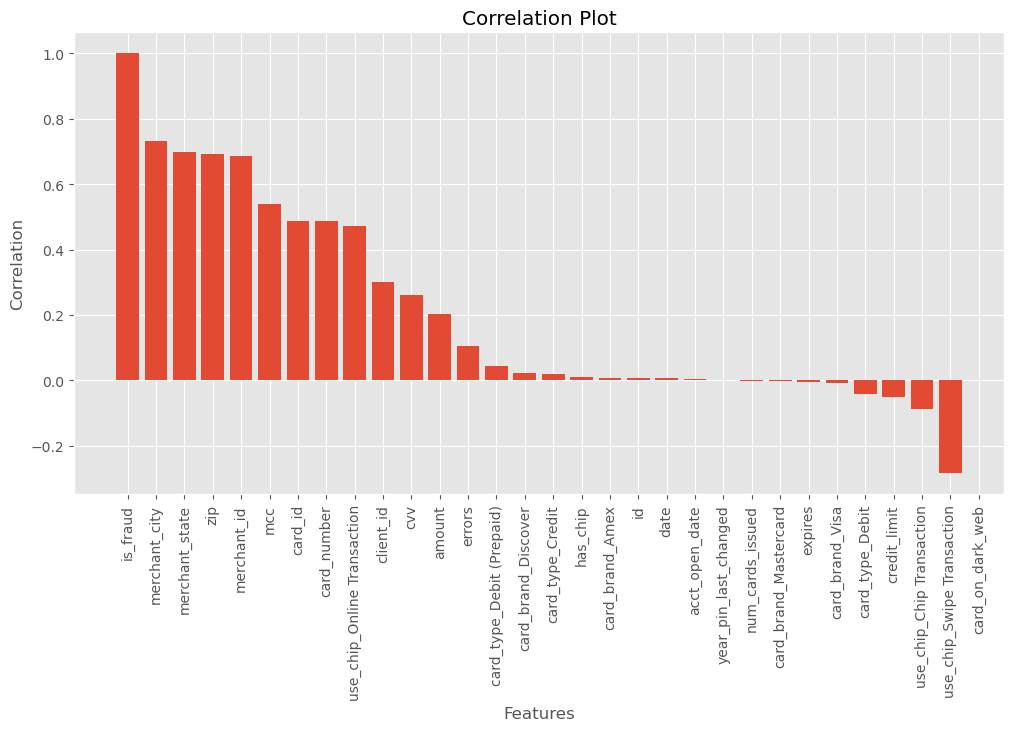

In [12]:
plotter_corr.plot_correlations()

As we can see there are many features with almost no correlation. When modelling we will remove features with <0.05 correlation!

**Ideas for Further Modelling**

* Cities with most fraudulent transactions
* States with most fraudulent transactions (Geo plot for bonus points)
* Regression plot with amount
* Most fraudulent MCCs

In [21]:
# Obtaining a smaller df to work with

df_for_plotting = general_transformation_pipeline.fit_transform(merged_df)

/home/as3620/FODS_coursework/LoanPrediction/Modules/transforming.py:53: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return pd.to_datetime(X).to_frame()
/home/as3620/FODS_coursework/LoanPrediction/Modules/transforming.py:53: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return pd.to_datetime(X).to_frame()


In [22]:
# Mapping relevant mcc codes for purpouse of plotting

df_for_plotting["mcc"] = df_for_plotting["mcc"].astype(str).map(mcc_data)

In [23]:
# New plotter instance
plotter_plot = Plotter(df=df_for_plotting)

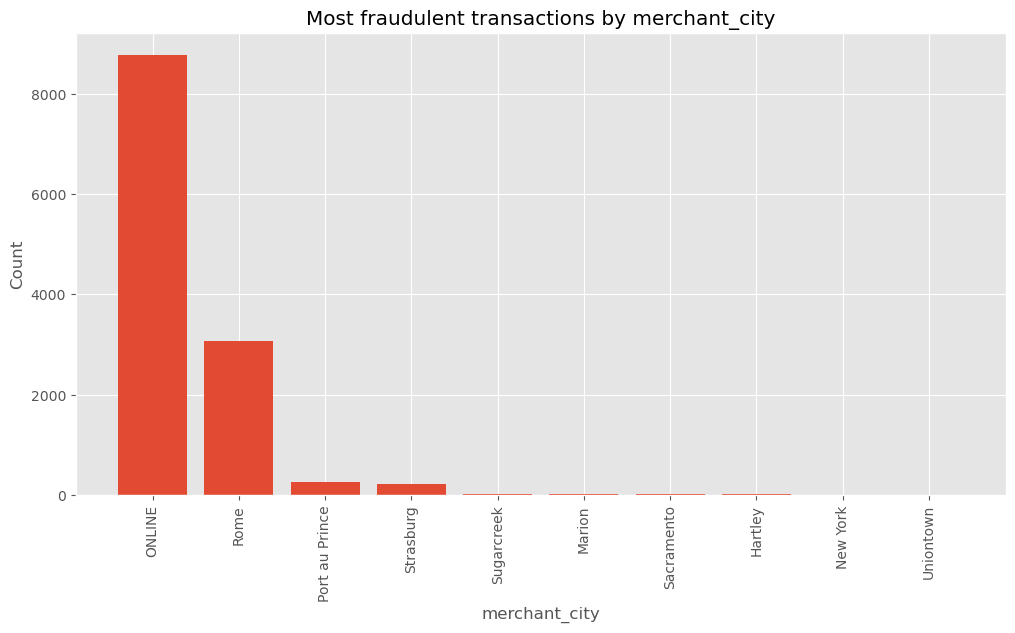

In [24]:
plotter_plot.bar_plot(feature_of_interest="merchant_city", top_n=10)

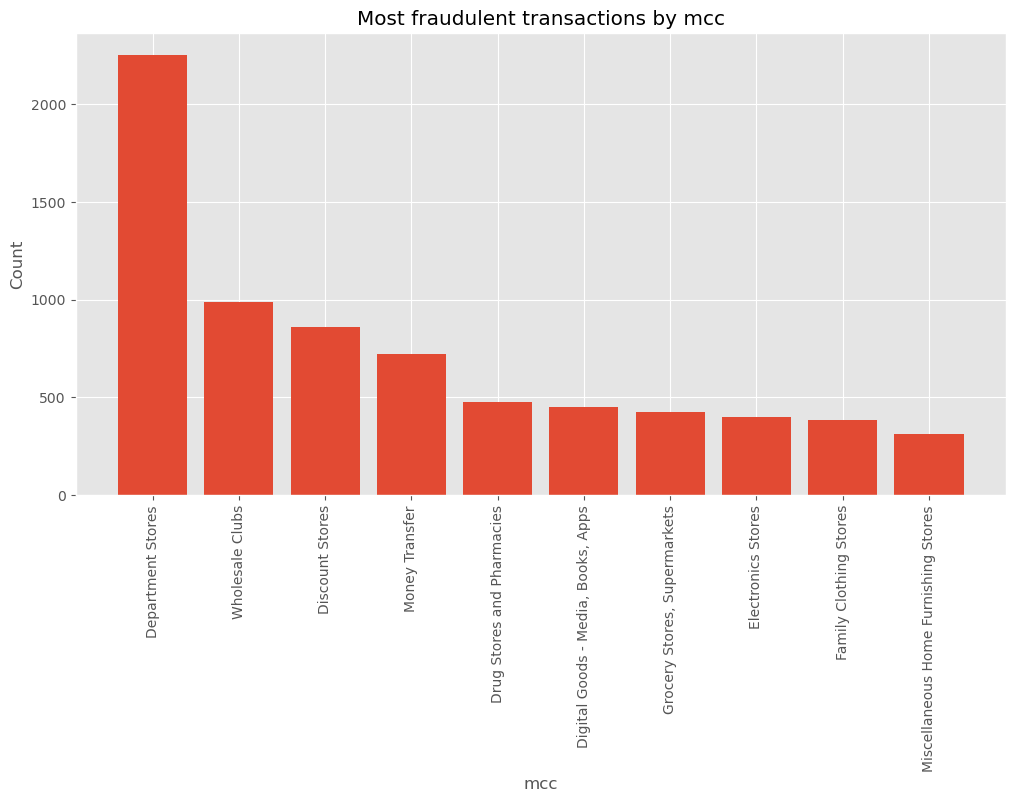

In [25]:
plotter_plot.bar_plot(feature_of_interest="mcc", top_n=10)

### Does extracting more information from date features make a difference?

In [26]:
general_df2 = general_transformation_pipeline2.fit_transform(merged_df)

/home/as3620/FODS_coursework/LoanPrediction/Modules/transforming.py:53: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return pd.to_datetime(X).to_frame()
/home/as3620/FODS_coursework/LoanPrediction/Modules/transforming.py:53: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return pd.to_datetime(X).to_frame()


In [27]:
df2 = Pipeline_for_exploration2.fit_transform(general_df2)

In [28]:
## Plotting correlations
Plotter3 = Plotter(df=df2)

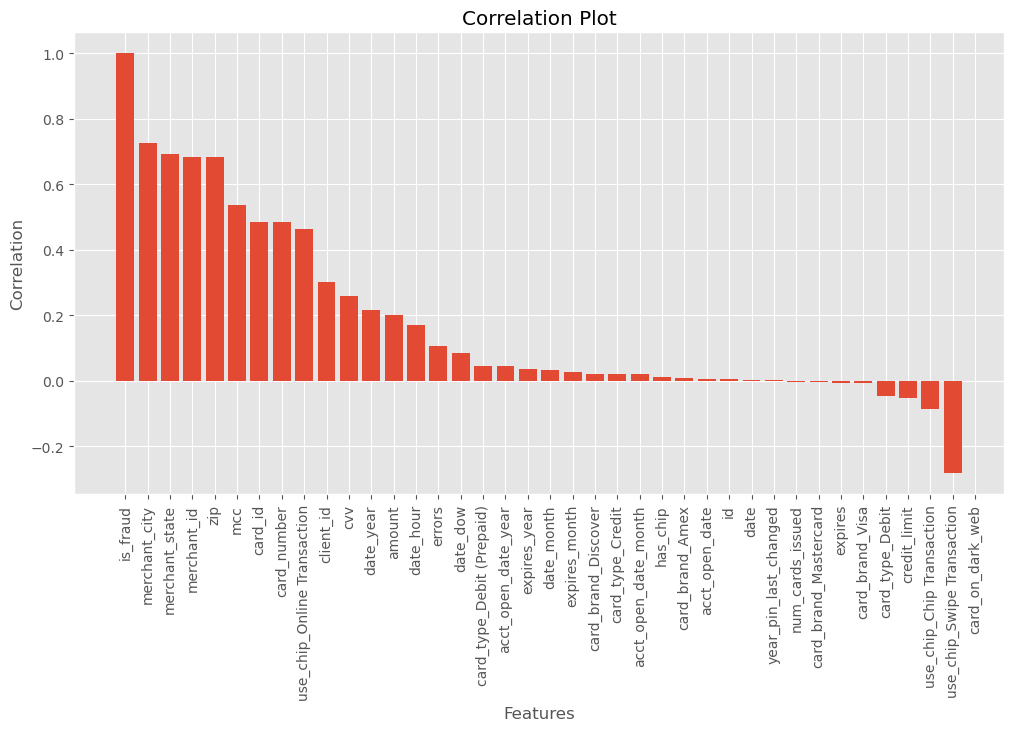

In [29]:
Plotter3.plot_correlations()

We can see that Fraudulent transactions are more common in certain times, days etc.!